In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.utils.data as data
import time
import matplotlib.pyplot as plt


In [2]:
import torch
import numpy
print(torch.__version__)

2.6.0+cpu


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

basic_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

augmentation_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root="C:\\Users\\Admin\\Documents\\Codes\\Python\\Pytorch\\Cats_dogs\\dataset\\train", transform=basic_transform)
test_dataset = datasets.ImageFolder(root="C:\\Users\\Admin\\Documents\\Codes\\Python\\Pytorch\\Cats_dogs\\dataset\\train", transform=basic_transform)  

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = data.random_split(train_dataset, [train_size, val_size])

train_dataset.dataset.transform = augmentation_transform

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, use_dropout=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) if use_dropout else None

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 32 * 32)  # Flatten the input
        x = self.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x



In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    train_losses, val_losses = [], []
    start_time = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    training_time = time.time() - start_time
    return train_losses, val_losses, training_time

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy



Training with L2 regularization...
Epoch [1/10], Train Loss: 0.7617, Val Loss: 0.6190
Epoch [2/10], Train Loss: 0.5796, Val Loss: 0.5518
Epoch [3/10], Train Loss: 0.5251, Val Loss: 0.5515
Epoch [4/10], Train Loss: 0.4907, Val Loss: 0.5132
Epoch [5/10], Train Loss: 0.4630, Val Loss: 0.4871
Epoch [6/10], Train Loss: 0.4419, Val Loss: 0.4827
Epoch [7/10], Train Loss: 0.4329, Val Loss: 0.4860
Epoch [8/10], Train Loss: 0.4141, Val Loss: 0.5094
Epoch [9/10], Train Loss: 0.3957, Val Loss: 0.4804
Epoch [10/10], Train Loss: 0.3687, Val Loss: 0.4520
L2 Test Accuracy: 84.63%

Training with Dropout...
Epoch [1/10], Train Loss: 0.7325, Val Loss: 0.6157
Epoch [2/10], Train Loss: 0.5840, Val Loss: 0.5734
Epoch [3/10], Train Loss: 0.5440, Val Loss: 0.5257
Epoch [4/10], Train Loss: 0.5010, Val Loss: 0.5371
Epoch [5/10], Train Loss: 0.4716, Val Loss: 0.4982
Epoch [6/10], Train Loss: 0.4418, Val Loss: 0.5589
Epoch [7/10], Train Loss: 0.4222, Val Loss: 0.4674
Epoch [8/10], Train Loss: 0.3964, Val Loss: 0.

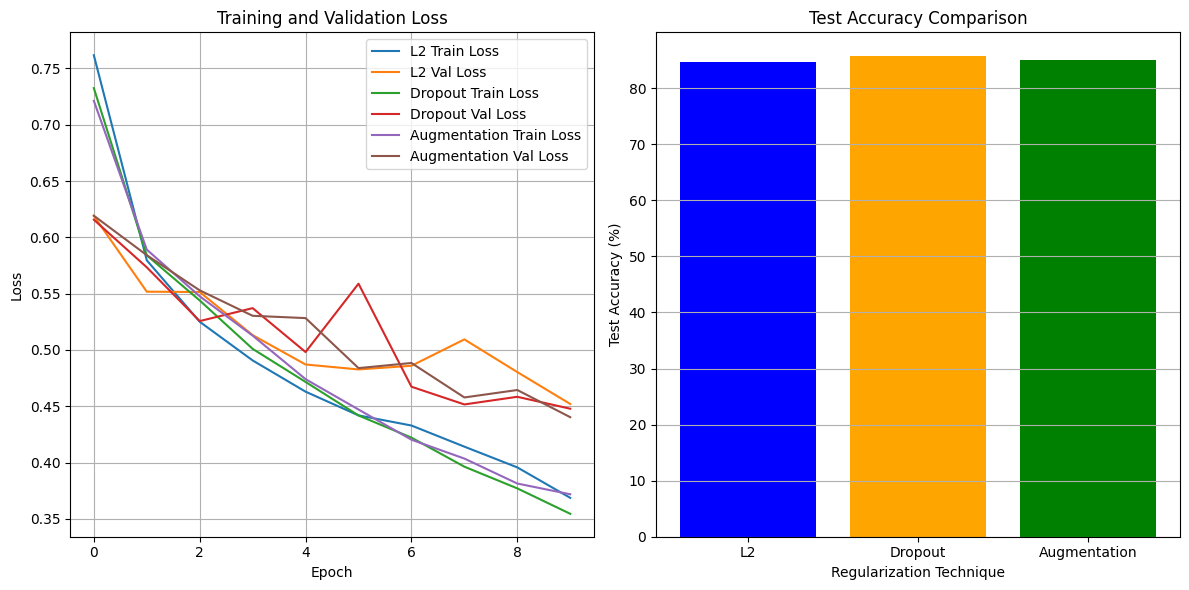

In [ ]:
model_l2 = SimpleCNN().to(device)
model_dropout = SimpleCNN(use_dropout=True).to(device)
model_augmentation = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
l2_optimizer = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=1e-5)  
dropout_optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)
augmentation_optimizer = optim.Adam(model_augmentation.parameters(), lr=0.001)

# Train and evaluate with L2 regularization
print("Training with L2 regularization...")
train_losses_l2, val_losses_l2, l2_time = train_model(model_l2, train_loader, val_loader, criterion, l2_optimizer, device)
l2_accuracy = evaluate_model(model_l2, test_loader, device)
print(f"L2 Test Accuracy: {l2_accuracy:.2f}%")

# Train and evaluate with Dropout
print("\nTraining with Dropout...")
train_losses_dropout, val_losses_dropout, dropout_time = train_model(model_dropout, train_loader, val_loader, criterion, dropout_optimizer, device)
dropout_accuracy = evaluate_model(model_dropout, test_loader, device)
print(f"Dropout Test Accuracy: {dropout_accuracy:.2f}%")

# Train and evaluate with Data Augmentation
print("\nTraining with Data Augmentation...")
train_losses_augmentation, val_losses_augmentation, augmentation_time = train_model(model_augmentation, train_loader, val_loader, criterion, augmentation_optimizer, device)
augmentation_accuracy = evaluate_model(model_augmentation, test_loader, device)
print(f"Augmentation Test Accuracy: {augmentation_accuracy:.2f}%")

# Plot results


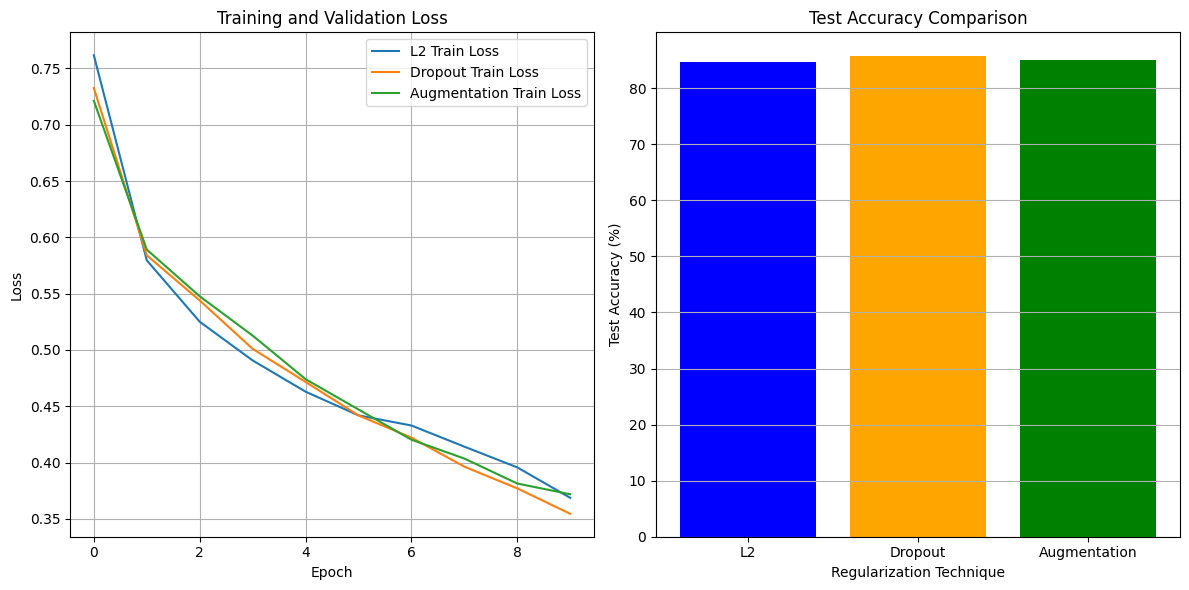

In [8]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss for each model
plt.subplot(1, 2, 1)
plt.plot(train_losses_l2, label="L2 Train Loss")
plt.plot(train_losses_dropout, label="Dropout Train Loss")
plt.plot(train_losses_augmentation, label="Augmentation Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

# Plot test accuracies
plt.subplot(1, 2, 2)
plt.bar(["L2", "Dropout", "Augmentation"], [l2_accuracy, dropout_accuracy, augmentation_accuracy], color=["blue", "orange", "green"])
plt.xlabel("Regularization Technique")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy Comparison")
plt.grid(axis="y")

plt.tight_layout()
plt.show()